# CS194 Project 3
## Facial Morphing 

**Overview**

In this assignment you will produce a "morph" animation of your face into someone else's face, compute the mean of a population of faces and extrapolate from a population mean to create a caricature of yourself.

A morph is a simultaneous warp of the image shape and a cross-dissolve of the image colors. The cross-dissolve is the easy part; controlling and doing the warp is the hard part. The warp is controlled by defining a correspondence between the two pictures. The correspondence should map eyes to eyes, mouth to mouth, chin to chin, ears to ears, etc., to get the smoothest transformations possible.

To start with, you should take a pictures of yourself on a uniform background (for instance, white). Your image should be the same size and aspect ratio as your target face (for instance, this beautiful portrait of George, taken by Martin Schoeller). Treat your target face as a passport photo template -- your face in the picture should be about where their face is. This will make your morphing result more pleasing to the eye.

Use your photo as Picture A and your target person's photo as Picture B. You'll morph still picture A into still picture B and produce 45 frames of animation numbered 0-45, where frame 0 must be identical to picture A and frame 45 must be identical to picture B. In the video, each frame will be displayed for 1/30 of a second. Create a video from your sequence of frames, either a YouTube or an animated gif.

**Defining Correspondences**

First, you will need to define pairs of corresponding points on the two images by hand (the more points, the better the morph, generally). The simplest way is probably to use the cpselect (matlab) tool or write your own little tool using 'ginput' (matlab or python) and plot commands (with hold on and hold off ). In order for the morph to work you will need a consistent labeling of the two faces. So label your faces A and B in a consistent manner using the same ordering of keypoints in the two faces. It's strongly recommended that you save the points once you obtain something you are happy with so that you don't have to do all that clicking more than once!

Now, you need to provide a triangulation of these points that will be used for morphing. You can compute a triangulation any way you like, or even define it by hand. A Delaunay triangulation (see dalaunay and related functions) is a good choice since it does not produce overly skinny triangles. You can compute the Delaunay triangulation on either of the point sets (but not both -- the triangulation has to be the same throughout the morph!). But the best approach would probably be to compute the triangulation at midway shape (i.e. mean of the two point sets) to lessen the potential triangle deformations.



In [1]:
import pandas as pd
import numpy as np
#import sk something
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import warnings
warnings.filterwarnings("ignore")

def compute_spacial_mean(x1, x2, y1, y2, a=.5):
    x1,x2 = a*np.array(x1), (1-a)*np.array(x2)
    y1, y2 = a*np.array(y1), (1-a)*np.array(y2)
    x = np.stack([x1,x2], axis=1)
    y = np.stack([y1,y2], axis=1)
    x_, y_ = np.sum(x, axis=1), np.sum(y, axis=1)
    data = []
    for i,j in zip(x_, y_):
        data.append([i,j])
    return np.array(data)

def compute_del(x1,x2, y1, y2, a=.5):
    data = compute_spacial_mean(x1, x2, y1, y2, a)
    return Delaunay(data)

def show_triangulation(im_path, x1,x2,y1,y2, a=.5, save=False):
    if type(im_path) != type(np.array([1])):
        print(1)
        img = plt.imread(im_path)
    else:
        img = im_path
    plt.imshow(img)
    points = compute_spacial_mean(x1,x2,y1,y2, a)
    delaun = compute_del(x1,x2,y1,y2)
    plt.triplot(points[:, 0], points[:, 1], delaun.simplices)
    plt.plot(points[:, 0], points[:, 1], 'o')
    if save:
        plt.savefig('site/assets/'+save)
    plt.show()
    
    

df = pd.read_csv('corr.csv')
x1, y1 = np.array(df['im1_x']), np.array(df['im1_y'])
x2, y2 = np.array(df['im2_x']), np.array(df['im2_y'])
im1_points = np.array([[a,b] for a,b in zip(x1, y1)])
im2_points = np.array([[a,b] for a,b in zip(x2, y2)])

me = plt.imread('imgs/me_resized.jpg')

1


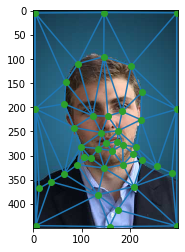

In [2]:
show_triangulation('imgs/me_resized.jpg', x1,x2,y1,y2, save='triangle_mask.jpg')
#might have to redo with the edges of the image and better scaled

1


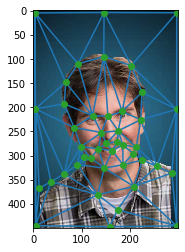

In [3]:
show_triangulation('imgs/john.jpg', x1,x2,y1,y2)

**Computing the "Mid-way Face"**

Before computing the whole morph sequence, compute the mid-way face of your images A and B. This would involve: 1) computing the average shape (a.k.a the average of each keypoint location in the two faces), 2) warping both faces into that shape, and 3) averaging the colors together. The main task in warping the faces into the average shape is implementing an affine warp for each triangle in the triangulation from the original images into this new shape. This will involve computing an affine transformation matrix A between two triangles:

A = computeAffine(tri1_pts,tri2_pts)
(You will write this function.)

A set of these transformation matrices will then need to be used to implement an inverse warp (as discussed in class) of all pixels. One way to do so is to generate a mask directly using polygon in python or roipoly in MATLAB.

Show us the original A and B images as well as the image of the mid-way face that you got.


In [4]:
from skimage.draw import polygon
def show_triangle(img, index, points, delu):
    tri = np.array(points[delu.simplices[index]])
    rr, cc = polygon(tri[:,1], tri[:,0])
    temp_img = img.copy()
    temp_img[rr,cc,:] = 1
    plt.imshow(temp_img)


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
john = plt.imread('imgs/john.jpg')
points = compute_spacial_mean(x1,x2,y1,y2)
d = compute_del(x1,x2,y1,y2)
interact(show_triangle, img = fixed(john),index=widgets.IntSlider(min=0, max=d.simplices.shape[0]-1,\
                                                        step=1, value=0), points=fixed(points), delu= fixed(d));

interactive(children=(IntSlider(value=0, description='index', max=76), Output()), _dom_classes=('widget-intera…

In [34]:
def computeAffine(t1, t2):
    original = np.vstack([t1.T, [1, 1, 1]]).T
    new = np.vstack([t2.T, [1, 1, 1]]).T
    return (np.linalg.solve(original, new)).T

def get_transition_matricies(original_shape, new_shape, delu):
    original_points = original_shape[delu.simplices]
    new_points = new_shape[delu.simplices]
    
    transition_matricies = []
    for x,y in zip(original_points, new_points):
        matrix = computeAffine(x,y)
        transition_matricies.append(matrix)
    return np.array(transition_matricies)
 
def affineTransform(im1, original_shape, new_shape, delu, grayscale=False):
    """
    parameters:
        im1 (array): picture
        original_shape:  array of [x,y] coord arrays
        new_shape: same as above but final shape
        delu: compute_del(x1,x2,y1,y2)
        
    """
    transition_matricies = get_transition_matricies(original_shape, new_shape, delu)
    new_img = np.zeros(im1.shape)
    new_points = new_shape[delu.simplices]
    
    for new_point, matrix in zip(new_points, transition_matricies):
        rr, cc = polygon(new_point[:,1].T, new_point[:,0].T)
        mask = np.zeros(im1.shape)
        mask[rr, cc] = 1
        if grayscale:
            y, x = np.where(mask[:, :])
        else:
            y, x = np.where(mask[:, :, 0])
        final_points = np.vstack([x, y, np.ones(x.shape)]).astype(int)
        index = matrix.dot(final_points).astype(int)
        r = np.clip(index[1], 0, im1.shape[0]-1)
        c = np.clip(index[0], 0, im1.shape[1]-1)
        
        if grayscale:
            new_img[final_points[1], final_points[0]] = im1[r, c]
        else:
            new_img[final_points[1], final_points[0], :] = im1[r, c, :]
        
    return new_img.astype(int)
    

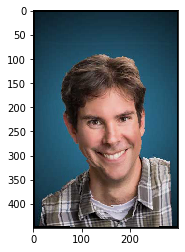

In [6]:
plt.imshow(affineTransform(john, im2_points, compute_spacial_mean(x1,x2,y1,y2), compute_del(x1,x2,y1,y2)));

In [7]:
def weight_mean(c1, c2, a=.5):
    t1, t2 = c1*a, c2*(1-a)
    return np.sum([t1,t2], axis=0)
    
def avg_color(im1, im2, a=.5):
    r1, g1, b1 = im1[:,:,0],im1[:,:,1], im1[:,:,2]
    r2, g2, b2 = im2[:,:,0],im2[:,:,1], im2[:,:,2]
    r = weight_mean(r1, r2,a)
    g = weight_mean(g1,g2, a)
    b = weight_mean(b1,b2,a)
    return np.dstack([r,g,b]).astype(int)


In [8]:
def half_way(im1,x1, x2, y1, y2, a=.5):
    new_shape = compute_spacial_mean(x1,x2,y1,y2,a)
    triangles = compute_del(x1,x2,y1,y2, a)
    points = np.array([[a,b] for a,b in zip(x1, y1)])
    return affineTransform(im1, points, new_shape, triangles)
    
    
def merge(im1, im2, corr,a):
    x1,x2,y1,y2 = corr
    img_1 = half_way(im1, x1,x2,y1,y2, a)
    img_2 = half_way(im2, x1,x2,y1,y2,(1-a)) 
    return avg_color(img_1,img_2, a)
    

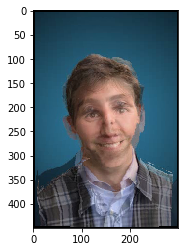

In [9]:
corr = (x1,x2,y1,y2)
plt.imshow(merge(me, john, corr, .5))
#halfway image
plt.imsave('site/assets/imgs/midway.jpg',(merge(me, john, corr, .5)/255).astype(float) )

**The Morph Sequence**

You need to write a function:

morphed_im = morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac);

that produces a warp between im1 and im2 using point correspondences defined in im1_pts and im2_pts (which are both n-by-2 matrices of (x,y) locations) and the triangulation structure tri . The parameters warp_frac and dissolve_frac control shape warping and cross-dissolve, respectively. In particular, images im1 and im2 are first warped into an intermediate shape configuration controlled by warp_frac, and then cross-dissolved according to dissolve_frac. For interpolation, both parameters lie in the range [0,1]. They are the only parameters that will vary from frame to frame in the animation. For your starting frame, they will both equal 0, and for your ending frame, they will both equal 1.

The output of this part should be a video sequence of a morph from your image A to image B. Please do NOT put a video file on your website! Either include a link to a YouTube video, or create an animated gif.

In [10]:
corr = (x1,x2,y1,y2)
def wrapper(im1, im2, corr, a):
    t = merge(im1, im2, corr, a)
    plt.imshow(t)
interact(wrapper, im1 = fixed(me), im2 = fixed(john), corr = fixed(corr), \
         a=widgets.FloatSlider(min=0, max=1,step=.1, value=.5));


interactive(children=(FloatSlider(value=0.5, description='a', max=1.0), Output()), _dom_classes=('widget-inter…

**The "Mean face" of a population**

Pick a freely available dataset of annotated faces (for instance the Danes or this one or something from here or ask for permission to use this one). Using the keypoints already annotated on the data:

Compute the average face shape of the whole population or some subset of the population - say, all the girls or all the old/young/white/asian/blond etc. However, if you pick a subpopulation - make sure it contains enough faces for this to be interesting.

Morph each of the faces in the dataset into the average shape. Show us some examples.
Compute the average face of the population and display it.
Show the mean image that you got, as well as 1) your face warped into the average geometry, and 2) the average face warped into your geometry.

**Caricatures: Extrapolating from the mean**

Produce a caricature of your face by extrapolating from the population mean you calculated in the last step. This might work better if you have gender-specific mean or a mean of a subset of the population that look similar to you.

Database credit: M. B. Stegmann, B. K. Ersb¿ll, and R. Larsen. FAME { a °exible appearance modelling
environment. IEEE Trans. on Medical Imaging, 22(10):1319{1331, 2003

In [11]:
import re
from scipy.spatial.distance import euclidean

def mask(arr, space=7):
    """returns a new array with like every 4th enrty from the original"""
    return arr[::space]
        
def parse_asf(path):
    file1 = open(path, 'r')
    lines = file1.readlines()
    path_, type_, x, y, point, to, from_ = [],[],[],[],[],[],[]
    for line in lines:
        if line[0]!= '#' and line[0] != None:
            arr = re.split(r'\s+',line)
            if len(arr) > 3:
                path_.append(int(arr[0]))
                type_.append(int(arr[1]))
                x.append(float(arr[2]))
                y.append(float(arr[3]))
                point.append(int(arr[4]))
                to.append(int(arr[5]))
                from_.append(int(arr[6]))
    if len(x) == 0:
        print(path)
        
    #parsing the annotations... they put like 40 points in the eyes and its messing up my triangle
    #x = mask(x)
    #y = mask(y)
    #manually adding edges
    x.extend([0,.5,.5,0,0,1,1,1])
    y.extend([0,0,.5,.5,1,0,1,.5])
    
    dic = {'path':path_,
           'type': type_,
           'x':x,
           'y':y,
           'point':point,
           'to':to,
           'from':from_}
    return dic
                
            

### Im going to track down and stab whoever made this wack file format

In [12]:
import os
dfs = {}
imgs = {}
directory = 'imm_face_db/'
for filename in os.listdir(directory):
    name, filetype = filename.split('.')
    if filetype == 'asf':
        path = directory + filename
        dfs[name] = parse_asf(path)
    if filetype == 'jpg':
        path = directory + filename
        array = plt.imread(path)
        imgs[name] = array
    

In [13]:
def get_info(name):
    img = imgs[name]
    df = dfs[name]
    x,y = np.array(df['x'])*img.shape[1], np.array(df['y'])*img.shape[0]
    return img, x , y

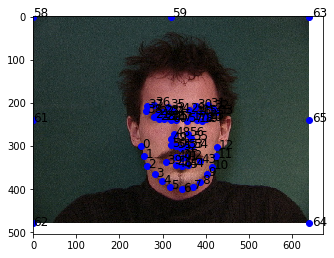

In [14]:
pic, x_, y_ = get_info('10-1m')
plt.imshow(pic)


for i in range(len(x_)):
    x = x_[i]
    y = y_[i]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)

In [15]:
frontal_nutral_male = []
frontal_happy_male = []
frontal_nutral_women = []
frontal_happy_women = []

for name in dfs.keys():
    #1 = nutral
    #2 = happy
    string = name.split('-')[-1]
    if string[-1] == 'm':
        if string[0] == '1':
            frontal_nutral_male.append(name)
        if string[1] == '2':
            frontal_happy_male.append(name)
    else:
        if string[0] == '1':
            frontal_nutral_women.append(name)
        if string[1] == '2':
            frontal_happy_women.append(name)

pics_n_male, x_n_male, y_n_male = [], [], []
for name in frontal_nutral_male:
    t1, t2, t3 = get_info(name)
    if t1.size:
        pics_n_male.append(t1)
    if t2.size:
        x_n_male.append(t2)
    if t3.size:
        y_n_male.append(t3)

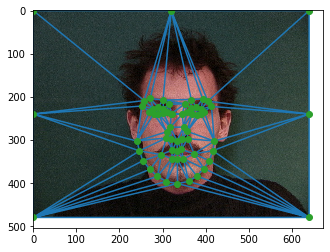

In [16]:
x_avg_n_male = np.mean(np.array(x_n_male), axis=0)
y_avg_n_male = np.mean(np.array(y_n_male), axis=0)
show_triangulation(pic, x_,x_avg_n_male,y_,y_avg_n_male)

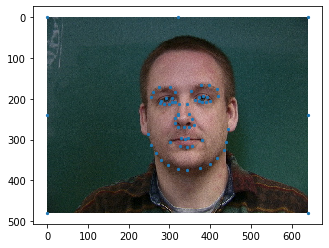

In [17]:
plt.imshow(pics_n_male[2])
plt.scatter(x_n_male[2], y_n_male[2], s=5)

In [35]:
#making array of faces morphed to the avg
avg_transformed_faces = []
for x in range(len(pics_n_male)):
    original_x, original_y = x_n_male[x], y_n_male[x]
    triangles = compute_del(original_x, x_avg_n_male, original_y, y_avg_n_male)
    original_points = np.array([[a,b] for a,b in zip(original_x, original_y)])
    new_points = np.array([[a,b] for a,b in zip(x_avg_n_male, y_avg_n_male)])
    temp = affineTransform(pics_n_male[x], original_points, new_points, triangles)
    avg_transformed_faces.append(temp)
    
    
    

this isn't working because this set of labels didnt do the edges. I think i can manually add them...
need to add :
0,0
.5,0
.5,.5
0,.5
0,1
1,0
1,1
1,.5
to every picture....

In [ ]:
def show_array(array,index):
    plt.imshow(array[index])
    
interact(show_array, array = fixed(avg_transformed_faces),index=widgets.IntSlider(min=0, max=len(avg_transformed_faces)-1,step=1, value=0));


In [19]:
def parse_pts(file):
    f = open(file)
    lines= f.readlines()
    x_,y_, marker = [],[], False
    for line in lines:
        if marker and line[0] != '}':
            x,y = line.split(' ')
            x,y = float(x), float(y)
            x_.append(x)
            y_.append(y)
        if line[0] == '{':
            marker = True
    return x_, y_

In [20]:
def parse_directory(directory):
    pictures, points = {}, {}
    for filename in os.listdir(directory):
        name, filetype = filename.split('.')
        if filetype == 'pts':
            x,y = parse_pts(directory+filename)
            y.extend([0,300, 0, 300, 0])
            x.extend([0, 0, 250, 250, 125])
            points[name] = np.stack([np.array(x), np.array(y)])
        if filetype == 'jpg':
            img = plt.imread(directory+filename)
            pictures[name] = img

    return pictures, points
    

In [21]:
_men = ['1a', '31a', '36a', '95a', '81a', '77a', '71a', '65a']
curated = ['1a','31a', '36a' ]

In [22]:
pictures, points = parse_directory('facial_data/')
database = []
for name in _men:
    img = pictures[name]
    x,y = points[name]
    database.append((img,x,y))
    
x_mean = np.mean(np.array([x[1] for x in database]), axis=0)
y_mean = np.mean(np.array([x[2] for x in database]), axis=0)

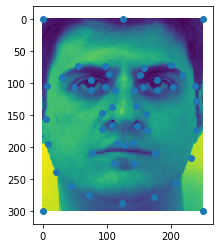

In [23]:
test_x,test_y = points['1a']
test_pic = pictures['1a']
plt.imshow(test_pic)
plt.scatter(test_x,test_y)

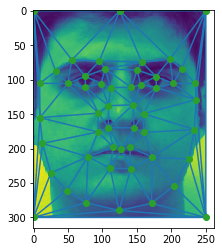

In [24]:
show_triangulation(test_pic, test_x, x_mean, test_y, y_mean)


In [25]:

#orig_points = np.array([[a,b] for a,b in zip(test_x,test_y)])
#new_points = np.array([[a,b] for a,b in zip(x_mean, y_mean)])
#triangle = compute_del(test_x,x_mean, test_y, y_mean)
#plt.imshow(affineTransform(test_pic,orig_points, new_points, triangle, grayscale=True ))

transformed_imgs = []
for d in database:
    orig_points = np.array([[a,b] for a,b in zip(d[1],d[2])])
    new_points = np.array([[a,b] for a,b in zip(x_mean, y_mean)])
    triangle = compute_del(d[1],x_mean, d[2], y_mean)
    pic = affineTransform(d[0],orig_points, new_points, triangle, grayscale=True)
    transformed_imgs.append(pic)
    

In [26]:
def show_array(array,index):
    plt.imshow(array[index], cmap='gray')
    
interact(show_array, array = fixed(transformed_imgs),index=widgets.IntSlider(min=0, max=len(transformed_imgs)-1,step=1, value=0));


interactive(children=(IntSlider(value=0, description='index', max=7), Output()), _dom_classes=('widget-interac…

In [27]:
me_avg = plt.imread('me_avg.jpg')
temp_df = pd.read_csv('me_avg.csv')
me_avg_x, me_avg_y = temp_df['im1_x'], temp_df['im1_y']

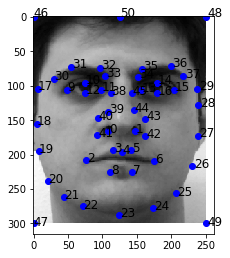

In [28]:
plt.imshow(test_pic, cmap='gray')


for i in range(len(test_x)):
    x = test_x[i]
    y = test_y[i]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
    
plt.savefig('annotated_dude.jpg')

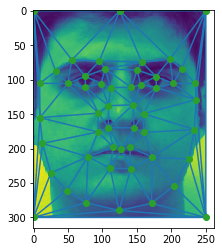

<Figure size 432x288 with 0 Axes>

In [29]:
show_triangulation(test_pic, test_x, x_mean, test_y, y_mean)
plt.savefig('triangulated_dude.jpg')

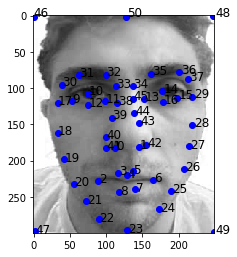

In [30]:
plt.imshow(me_avg[:,:,0], cmap='gray')


for i in range(len(me_avg_x)):
    x = me_avg_x[i]
    y = me_avg_y[i]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)

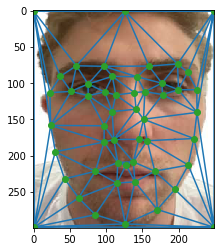

In [31]:
show_triangulation(me_avg, me_avg_x, x_mean, me_avg_y, y_mean)

In [47]:
orig_points = np.array([[a,b] for a,b in zip(me_avg_x, me_avg_y)])
new_points = np.array([[a,b] for a,b in zip(x_mean, y_mean)])
new_points = .5*new_points + .5*orig_points
triangle = compute_del(me_avg_x,x_mean, me_avg_y, y_mean)



me_to_avg = affineTransform(me_avg,orig_points, new_points, triangle )

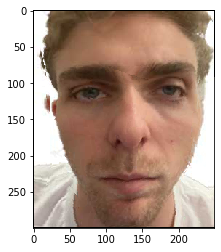

In [48]:
plt.imshow(me_to_avg)

In [ ]:
#plt.imsave('site/assets/imgs/better_affine.jpg',(me_to_avg/255).astype(float))

### Bells and whistles: automatic morphing
I got sick of manually adding points to im going to try to automate that

In [49]:
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2


In [50]:
shape_predictor = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)

def get_points(img):
    original_img = img
    if len(img.shape) == 3:
        img = img[:,:,0]
    original_shape = np.array(img.shape)
        
    rect = detector(img, 1)[0]
    landmarks = face_utils.shape_to_np(predictor(img, rect))
    x, y, w, h = face_utils.rect_to_bb(rect)
    cropped_img = original_img[y-25:y+150+25, x-25:x+150+25]
    x_, y_ = np.array(landmarks[:,0][::2]) - x +25 , np.array(landmarks[:,1][::2])-y+25
    x_ = np.append(x_, np.array([1, 1, cropped_img.shape[1]-1, cropped_img.shape[1]-1, cropped_img.shape[1]-1,\
                                 int(cropped_img.shape[1]/2), 1,int(cropped_img.shape[1]/2) ]))
    y_ = np.append(y_, np.array([1, cropped_img.shape[0]-1, 1 ,cropped_img.shape[0]-1, int(cropped_img.shape[1]/2), \
                                 cropped_img.shape[0]-1, int(cropped_img.shape[1]/2), 1]))

    return cropped_img, x_,y_

img, l_x, l_y = get_points(john)
img2, l2_x, l2_y = get_points(me)
        

(200, 200, 3) (200, 200, 3)


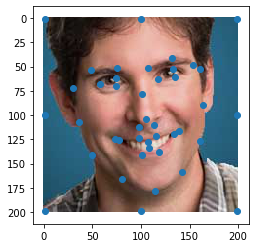

In [51]:
plt.imshow(img, cmap='gray')
plt.scatter(l_x, l_y)
#plt.imshow(img2)
#plt.scatter(l2_x, l2_y)
print(img.shape, img2.shape)

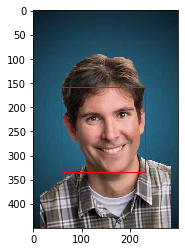

<Figure size 432x288 with 0 Axes>

In [111]:
import matplotlib.patches as patches
rect1 = detector(john[:,:,0], 1)[0]
xy = rect1.left()-25, rect1.top()-25
fig,ax = plt.subplots(1)
ax.imshow(john)
rect = patches.Rectangle(xy,175,175,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()
plt.savefig('site/assets/imgs/face_detect.jpg')

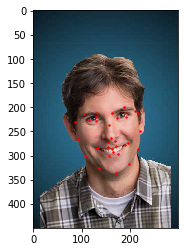

In [110]:
img = john[:,:,0]
rect = detector(img, 1)[0]
landmarks = face_utils.shape_to_np(predictor(img, rect))
plt.imshow(john)
plt.scatter(landmarks[:,0][::2], landmarks[:,1][::2], s=2, color='r')
plt.savefig('site/assets/imgs/feature_detect.jpg')

In [102]:
landmarks

array([[ 86, 231],
       [ 89, 248],
       [ 92, 266],
       [ 96, 284],
       [106, 300],
       [119, 314],
       [136, 325],
       [152, 336],
       [170, 337],
       [186, 331],
       [198, 318],
       [208, 303],
       [217, 286],
       [221, 268],
       [220, 249],
       [219, 231],
       [217, 212],
       [ 96, 223],
       [104, 213],
       [117, 210],
       [131, 211],
       [145, 215],
       [163, 211],
       [175, 205],
       [188, 200],
       [200, 201],
       [210, 207],
       [155, 224],
       [157, 237],
       [159, 250],
       [161, 263],
       [147, 269],
       [154, 271],
       [162, 273],
       [169, 269],
       [176, 264],
       [114, 227],
       [121, 221],
       [130, 221],
       [139, 227],
       [130, 229],
       [121, 229],
       [173, 222],
       [180, 214],
       [189, 212],
       [196, 216],
       [191, 220],
       [182, 222],
       [129, 284],
       [142, 284],
       [154, 283],
       [162, 284],
       [171,

In [ ]:
def auto_merge(img1, img2):
    cropped1, x1, y1 = get_points(img1) 
    cropped2, x2, y2 = get_points(img2) 
    corr = (x1,x2, y1, y2)
    frames = []
    for a in np.arange(0, 1.0333, .0333):   
        temp =merge(cropped1, cropped2, corr, a)
        frames.append(temp)
    return frames

In [ ]:
test_auto_merge = auto_merge(me, john)

In [ ]:
def show_array(array,index):
    plt.imshow(array[index], cmap='gray')
    
interact(show_array, array = fixed(test_auto_merge),index=widgets.IntSlider(min=0, max=len(test_auto_merge)-1,step=1, value=0));


In [ ]:
#import imageio #saved as a gif. didnt want to write over
#imageio.mimsave('automerge.gif', test_auto_merge)